****Assignment_4****



**Presented By:**

        Riya Shukla (22070126090)
        AIML-B1

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b0ac6a393aac2d2f161cf872b2ce4fac022ec330a23d94c8031e15ad3eb0874e
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
!pip install torchmetrics

In [3]:
!pip install torchmetrics[image] torch-fidelity

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from medmnist import ChestMNIST
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from torch.autograd import grad
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Load MedMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestMNIST(split='train', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 82.8M/82.8M [01:50<00:00, 750kB/s] 


In [8]:
# Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

In [9]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)

In [10]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [11]:
# Loss function selection
def get_loss_function(gan_type):
    if gan_type == "LS-GAN":
        return nn.MSELoss()
    elif gan_type == "WGAN":
        return None  # WGAN uses Wasserstein loss directly
    elif gan_type == "WGAN-GP":
        return None  # WGAN-GP requires gradient penalty
    else:
        raise ValueError("Unsupported GAN type")

gan_type = "LS-GAN"  # Change to "WGAN" or "WGAN-GP" as needed
criterion = get_loss_function(gan_type)

In [12]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
# TensorBoard setup
writer = SummaryWriter(f"runs/{gan_type}")

In [14]:
# Metrics (Inception Score and FID)
inception = InceptionScore(feature=64).to(device)
fid = FrechetInceptionDistance(feature=64).to(device)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 323MB/s]


In [15]:
# Convert images to uint8, expand grayscale to RGB, and resize to 299x299
def convert_to_uint8(images):
    images = ((images + 1) * 127.5).clamp(0, 255).to(torch.uint8)  # Normalize to 0-255
    if images.shape[1] == 1:  # If grayscale, convert to RGB
        images = images.repeat(1, 3, 1, 1)  # Repeat channels to create 3-channel RGB
    images = torch.nn.functional.interpolate(images.float(), size=(299, 299), mode='bilinear', align_corners=False)
    return images.to(torch.uint8)

In [16]:
# Training loop
num_epochs = 50
latent_dim = 100
lambda_gp = 10  # Gradient penalty coefficient

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        real_images = images.to(device)
        batch_size = real_images.size(0)
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(z)

        if gan_type == "LS-GAN":
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            real_loss = criterion(discriminator(real_images), real_labels)
            fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
        elif gan_type == "WGAN":
            d_loss = -torch.mean(discriminator(real_images)) + torch.mean(discriminator(fake_images.detach()))
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        elif gan_type == "WGAN-GP":
            alpha = torch.rand(batch_size, 1, device=device)
            interpolates = alpha * real_images + (1 - alpha) * fake_images.detach()
            interpolates.requires_grad_(True)
            d_interpolates = discriminator(interpolates)
            gradients = grad(outputs=d_interpolates, inputs=interpolates,
                             grad_outputs=torch.ones_like(d_interpolates),
                             create_graph=True, retain_graph=True)[0]
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            d_loss = -torch.mean(discriminator(real_images)) + torch.mean(discriminator(fake_images.detach())) + lambda_gp * gradient_penalty

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        if i % 5 == 0:
            g_loss = -torch.mean(discriminator(fake_images)) if gan_type in ["WGAN", "WGAN-GP"] else criterion(discriminator(fake_images), real_labels)
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        if i % 100 == 0:
            writer.add_scalar("Loss/Discriminator", d_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar("Loss/Generator", g_loss.item(), epoch * len(dataloader) + i)

    with torch.no_grad():
        sample_z = torch.randn(16, latent_dim, device=device)
        sample_images = generator(sample_z)
        sample_images_uint8 = convert_to_uint8(sample_images)
        real_images_uint8 = convert_to_uint8(real_images)
        inception.update(sample_images_uint8)
        inception_score, _ = inception.compute()  # Unpack the tuple

        inception.reset()
        fid.update(sample_images_uint8, real=False)
        fid.update(real_images_uint8, real=True)
        fid_score = fid.compute()
        fid.reset()
        writer.add_scalar("Metrics/Inception Score", inception_score.item(), epoch)
        writer.add_scalar("Metrics/FID", fid_score.item(), epoch)
        vutils.save_image(sample_images, f"generated_epoch_{epoch}.png", normalize=True)




writer.close()
print("Training complete!")


Training complete!



Training LS-GAN...


Training WGAN...


Training WGAN-GP...


===== FINAL COMPARISON RESULTS =====

LS-GAN:
  - Final Inception Score: 1.0332
  - Final FID Score: 354.2737

WGAN:
  - Final Inception Score: 1.0261
  - Final FID Score: 275.0643

WGAN-GP:
  - Final Inception Score: 1.0274
  - Final FID Score: 337.1579


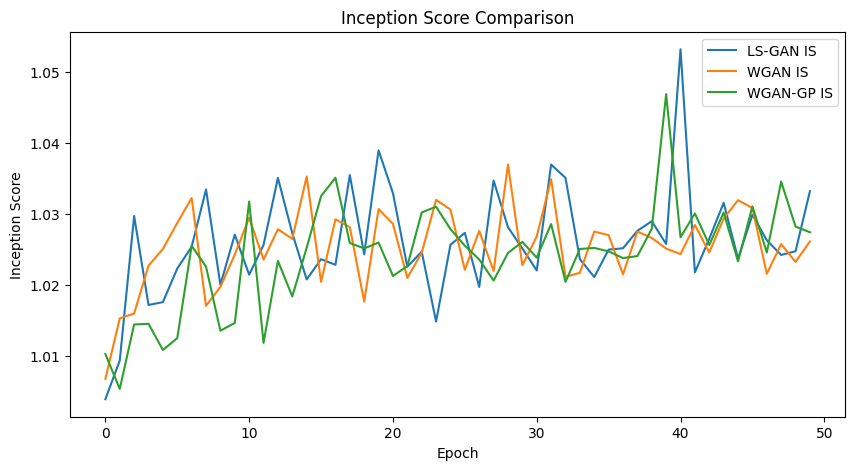

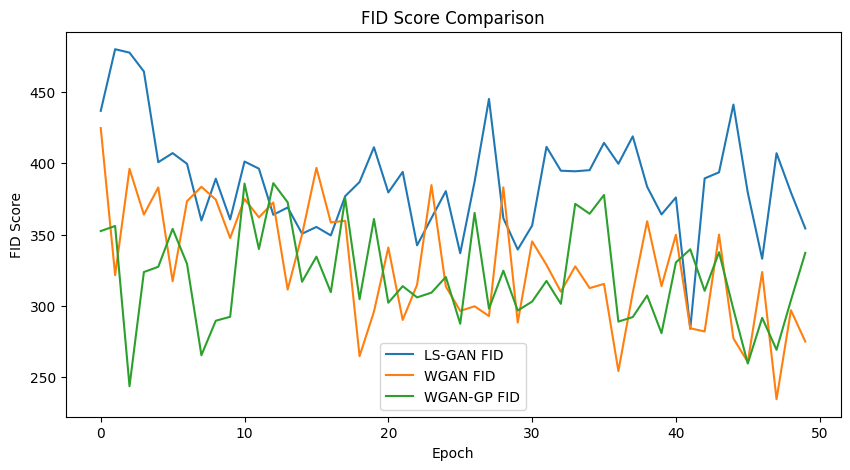

In [17]:
import matplotlib.pyplot as plt

gan_types = ["LS-GAN", "WGAN", "WGAN-GP"]
results = {}

for gan_type in gan_types:
    print(f"\nTraining {gan_type}...\n")
    criterion = get_loss_function(gan_type)
    writer = SummaryWriter(f"runs/{gan_type}")

    # Reinitialize models for fair comparison
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    inception = InceptionScore(feature=2048).to(device)
    fid = FrechetInceptionDistance(feature=2048).to(device)

    is_scores = []
    fid_scores = []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            real_images = images.to(device)
            batch_size = real_images.size(0)
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(z)

            if gan_type == "LS-GAN":
                real_labels = torch.ones(batch_size, 1, device=device)
                fake_labels = torch.zeros(batch_size, 1, device=device)
                real_loss = criterion(discriminator(real_images), real_labels)
                fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
                d_loss = real_loss + fake_loss
            elif gan_type == "WGAN":
                d_loss = -torch.mean(discriminator(real_images)) + torch.mean(discriminator(fake_images.detach()))
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
            elif gan_type == "WGAN-GP":
                alpha = torch.rand(batch_size, 1, 1, 1, device=device)  # Add extra dimensions
                interpolates = alpha * real_images + (1 - alpha) * fake_images.detach()

                interpolates.requires_grad_(True)
                d_interpolates = discriminator(interpolates)
                gradients = grad(outputs=d_interpolates, inputs=interpolates,
                                 grad_outputs=torch.ones_like(d_interpolates),
                                 create_graph=True, retain_graph=True)[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss = -torch.mean(discriminator(real_images)) + torch.mean(discriminator(fake_images.detach())) + lambda_gp * gradient_penalty

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            if i % 5 == 0:
                g_loss = -torch.mean(discriminator(fake_images)) if gan_type in ["WGAN", "WGAN-GP"] else criterion(discriminator(fake_images), real_labels)
                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()

        with torch.no_grad():
            sample_z = torch.randn(16, latent_dim, device=device)
            sample_images = generator(sample_z)

            sample_images_uint8 = convert_to_uint8(sample_images)
            real_images_uint8 = convert_to_uint8(real_images)

            inception.update(sample_images_uint8)
            inception_score, _ = inception.compute()
            inception.reset()

            fid.update(sample_images_uint8, real=False)
            fid.update(real_images_uint8, real=True)
            fid_score = fid.compute().item()
            fid.reset()

            is_scores.append(inception_score)
            fid_scores.append(fid_score)

            writer.add_scalar(f"{gan_type}/Inception Score", inception_score, epoch)
            writer.add_scalar(f"{gan_type}/FID", fid_score, epoch)

    results[gan_type] = {"IS": is_scores, "FID": fid_scores}
    writer.close()

# Print final comparison results
print("\n===== FINAL COMPARISON RESULTS =====")
for gan_type in gan_types:
    print(f"\n{gan_type}:")
    print(f"  - Final Inception Score: {results[gan_type]['IS'][-1]:.4f}")
    print(f"  - Final FID Score: {results[gan_type]['FID'][-1]:.4f}")

# Plot results in output
plt.figure(figsize=(10, 5))
for gan_type in gan_types:
    plt.plot(np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in results[gan_type]["IS"]]), label=f"{gan_type} IS")


plt.xlabel("Epoch")
plt.ylabel("Inception Score")
plt.legend()
plt.title("Inception Score Comparison")
plt.show()

plt.figure(figsize=(10, 5))
for gan_type in gan_types:
    plt.plot(np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in results[gan_type]["FID"]]), label=f"{gan_type} FID")

plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.title("FID Score Comparison")
plt.show()